<a href="https://colab.research.google.com/github/Jaesu26/Dacon-Basic/blob/main/%EC%88%98%ED%99%94%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98-DNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 수화 이미지 분류 경진대회

## 패키지 import

In [2]:
# !pip install albumentations==0.4.6
# !pip install adabelief-pytorch

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
import warnings
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings(action = 'ignore')

In [95]:
SEED = 22
N_FOLD = 10
SAVE_PATH = './weight3'
LEARNING_RATE = 1e-6
EPOCHS = 300
BATCH_SIZE = 24

In [5]:
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [7]:
%cd '/content/drive/MyDrive/Colab Notebooks/수화이미지-분류/Data'

/content/drive/MyDrive/Colab Notebooks/수화이미지-분류/Data


In [8]:
# !unzip -o '/content/drive/MyDrive/Dacon-Basic/수화이미지-분류/Data/user_data.zip의 사본'

In [9]:
%cd '/content/drive/MyDrive/Colab Notebooks/수화이미지-분류'

/content/drive/MyDrive/Colab Notebooks/수화이미지-분류


In [10]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  858 non-null    object
 1   label      858 non-null    object
dtypes: object(2)
memory usage: 13.5+ KB


`-` 결측치는 없다

In [12]:
df.head()

,file_name,label
0,001.png,10-2
1,002.png,10-1
2,003.png,3
3,004.png,8
4,005.png,9


`-` 파일 이름과 라벨명이 한 쌍으로 되어있음

- 가중치 저장 폴더 생성

In [104]:
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print(f'Error: Creating directory. {directory}')

In [59]:
create_folder(SAVE_PATH)

## 데이터 셋 및 딥러닝 모델 정의

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensor
from adabelief_pytorch import AdaBelief
import gc

In [14]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [17]:
def seed_everything(seed: int = 22):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [18]:
seed_everything(SEED) ## 재현을 위한 seed 고정

- 학습 이미지와 이미지 경로

In [19]:
def load_images(path):
    images = []
    for img in sorted(glob(path + '/*.png')): ## path에 들어있는 png 파일을 검색(1번부터 차례대로 검색해야 된다)
        an_img = PIL.Image.open(img)  
        img_array = np.array(an_img)  
        images.append(img_array)  
            
    images = np.array(images)
    return images

In [20]:
train_images = load_images(path='./Data/train')
test_images = load_images(path='./Data/test')

In [21]:
# train_img_path_list = sorted(glob('./Data/train/*.png'))
# test_img_path_list = sorted(glob('./Data/test/*.png'))

- 데이터 셋과 데이터 로더

In [22]:
class CustomDataset(Dataset):
  
    def __init__(self, images: np.array, label_list, train_mode=True, transforms=None):
        self.images = images
        self.label_list = label_list
        self.transforms = transforms
        self.train_mode = train_mode
    
    def __getitem__(self, idx):
        image = self.images[idx]    
        if self.transforms is not None:
            image = self.transforms(image=image)['image'] ## albumentations.Compose는 인자를 kwargs로 받는다

        if self.train_mode:
            label = self.label_list[idx]
            return image, label
        
        return image ## test는 라벨이 없다
    
    def __len__(self):
        return len(self.images) ## 데이터 개수 반환

- 데이터 변환

In [23]:
RGB_MEAN = [np.mean((train_images[..., i] / 255)) for i in range(3)] ## 255로 나눈후 RGB 각각의 평균
RGB_STD = [np.std(train_images[..., i] / 255) for i in range(3)]  ## 255로 나눈후 RGB 각각의 표준편차

In [96]:
## 데이터 변환 방식을 정의(Agumentation)
def get_transform(train_mode=True):
    transforms = A.Compose([
        # A.Resize(p=1, height=128, width=128), ## 높이 128, 너비 128로 resize
        A.Normalize(mean=RGB_MEAN, std=RGB_STD), ## 255로 값들을 나누고 표준화
        ToTensor() ## 이미지 타입이 unit8이면 255로 나누고 아니면 냅두고 torch.Tensor로 변환
    ])
    
    if train_mode:
        transforms = A.Compose([
            # A.Resize(p=1, height=128, width=128), ## 높이 128, 너비 128로 resize
            A.RandomGamma(gamma_limit=(90, 110), p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5), ## 무작위로 밝기와 대비를 조절
            A.OneOf(
                [
                    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, p=0.5), ## 생상과 채도 변경
                    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5) ## RGB color 변경 
                ],
                p=0.3
            ),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10), ## 실수로 중복적용 했는데 제외해도 성능에는 큰 차이 없을 듯 하다
            A.GaussNoise(p=0.5), ## 픽셀마다 잡음 추가
            A.HorizontalFlip(p=0.5), ## 50%의 확률로 수평으로 뒤집음
            A.Rotate(limit=10, p=1), ## 무작위로 -limit~limit 각도 회전
            A.Normalize(mean=RGB_MEAN, std=RGB_STD), ## 255로 값들을 나누고 표준화
            ToTensor() ## 이미지 타입이 unit8이면 255로 나누고 아니면 냅두고 torch.Tensor로 변환
        ])

    return transforms ## 데이터 변환 방식을 반환

`-` 라벨을 0~10로 변환하겠다

In [26]:
def get_label_map() -> dict:
    label_map = dict()
    label_map['10-1'] = 10
    label_map['10-2'] = 0
    
    for i in range(1, 10):
        label_map[str(i)] = i

    return label_map

In [27]:
def label_encoding_transform(label: pd.Series) -> pd.Series:
    label_map = get_label_map()
    encoded_label = label.apply(lambda x: label_map[x])
    return encoded_label

In [28]:
def label_encoding_inverse_transform(encoded_label: pd.Series) -> pd.Series:
    label_map = get_label_map()
    label_inverse_map = dict(zip(label_map.values(), label_map.keys()))
    label = encoded_label.apply(lambda x: label_inverse_map[x])
    return label

In [29]:
target = label_encoding_transform(df['label'])

- CNN 신경망

In [100]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.cnn_model = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding='same'), ## padding='same' 옵션을 사용할려면 stride가 1이어야 한다
            nn.GELU(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(kernel_size=(3, 3), stride=2), ## max pooling

            nn.Conv2d(32, 16, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(32),

            nn.MaxPool2d(kernel_size=(3, 3), stride=2), ## max pooling

            nn.Conv2d(32, 32, kernel_size=(5, 5), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 32, kernel_size=(5, 5), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(32),

            nn.MaxPool2d(kernel_size=(3, 3), stride=2), ## max pooling

            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 32, kernel_size=(3, 3), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(32),

            nn.MaxPool2d(kernel_size=(3, 3), stride=2), ## max pooling

            nn.Conv2d(32, 64, kernel_size=(5, 5), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 32, kernel_size=(5, 5), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(32),

            nn.MaxPool2d(kernel_size=(3, 3), stride=2), ## max pooling

            nn.Conv2d(32, 16, kernel_size=(1, 1), stride=1, padding='same'), 
            nn.GELU(), 
            nn.BatchNorm2d(16),

            nn.AdaptiveAvgPool2d(1) ## Flatten역할 ## 이미지를 평균내서 1*1 크기로 만든다
        )

        self.linear_model = nn.Sequential(
            nn.Linear(16, 64),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(64, 11) ## softmax는 옵티마이저(CrossEntorpyLoss)에서 수행
        )
      
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.squeeze()
        x = self.linear_model(x)
        return x

- Linear layer 가중치 초기화

In [32]:
## Linear layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0, 1/np.sqrt(y))
        m.bias.data.fill_(0)

- 조기 중단

In [33]:
class EarlyStopping:
    ## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', n_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint 저장 경로
                            Default: 'checkpoint.pt'
            n_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = None
        self.delta = delta
        self.path = path
        self.n_fold = n_fold

    def __call__(self, model, val_loss, val_acc):

        score = -val_loss ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: ## loss가 개선되지 않았을 때
            self.counter += 1 ## 카운팅 +1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: ## loss가 개선됨
            self.best_score = score ## score 갱신
            self.save_checkpoint(val_loss, val_acc, model) ## loss와 model 저장
            self.counter = 0 ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/best_{self.n_fold}.pt') ## 모델의 계층별 가중치를 지정한 경로에 저장
        self.val_loss_min = val_loss ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc ## 이때의 valid accuracy도 변경해준다

- 스케줄러

In [34]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    ## 코드: https://github.com/gaussian37/pytorch_deep_learning_models/blob/master/cosine_annealing_with_warmup/cosine_annealing_with_warmup.py
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
            
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

## 모델 교차검증

In [98]:
skfold = StratifiedKFold(n_splits=N_FOLD, random_state=SEED, shuffle=True) ## k겹 교차검증

In [92]:
## 손실 함수에 소프트맥스 함수 포함 -> net 내부에서 마지막 활성화함수로 소프트맥스 사용안해도 됨
## 라벨 스무딩 사용(오버피팅 방지)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)   

In [84]:
def train(model: nn.Module, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 epoch 하나당 batch들의 평균 훈련 오차를 반환"""
    model.train() ## 훈련모드
    train_avg_loss = 0 ## 에폭별 배치단위 평균 훈련 오차
    train_total_batch = len(dataloader) ## 배치 크기

    for X, y in dataloader: ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() ## 그래디언트 초기화
        yhat = model(X) ## y_hat을 구한다
        loss = loss_fn(yhat, y).to(device) ## 오차를 계산 ## train loss
        loss.backward()  ## 미분
        optimizer.step() ## 업데이트
        train_avg_loss += (loss.item() / train_total_batch) ## 각 배치마다 훈련 오차 누적

    ## epoch마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_avg_loss

In [38]:
def evaluate(model: nn.Module, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 모델에 대한 epoch 하나당 batch들의 평균 평가 오차와 평가 정확도를 반환"""
    valid_avg_acc, valid_avg_loss = 0, 0

    model.eval() ## 평가모드
    with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
        for X, y in dataloader: 
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y) ## valid loss
            acc = accuracy(y.cpu().data.numpy(), yhat.cpu().data.numpy().argmax(-1))       
            valid_avg_acc += (acc * len(y) / len(dataloader.dataset)) ## 각 배치마다 정확도(정답 개수 / 전체 개수)
            valid_avg_loss += loss.item() / len(dataloader) ## 각 배치마다 평가 오차 누적    

    return valid_avg_loss, valid_avg_acc

In [39]:
def show_loss_plot(train_loss: list, valid_loss: list, ax) -> None:
    epochs = len(train_loss)
    ax.set_title('Train Loss and Valid Loss')
    ax.plot(range(1, epochs+1), train_loss, label='Train')
    ax.plot(range(1, epochs+1), valid_loss, label='Valid')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

In [101]:
seed_everything(SEED) ## 정확한 loss 재현을 위함
net_avg_acc = [] ## fold별 valid셋의 평균 정확도
net_avg_loss = [] ## fold별 valid셋의 평균 손실
net_epoch_train_loss = [[] for _ in range(N_FOLD)] ## fold별 train셋의 한 epoch당 valid셋의 배치 평균 손실
net_epoch_valid_loss = [[] for _ in range(N_FOLD)] ## fold별 valid셋의 한 epoch당 valid셋의 배치 평균 손실

for i, (train_idx, valid_idx) in enumerate(skfold.split(train_images, target)):
    gc.collect()
    torch.cuda.empty_cache()
    print(f'[{i + 1} / {N_FOLD}] Fold Training......')
    
    X_train, X_valid = train_images[train_idx], train_images[valid_idx] 
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    
    ## early stopping
    early_stopping = EarlyStopping(patience=70,
                                   verbose=False,
                                   path=SAVE_PATH,
                                   n_fold=i+1) ## patience 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단
    
    ## CNN 모델
    net = CNN().to(device)
    net.apply(init_weights) ## Linear layer 가중치 초기화
    
    ## Dataset, Dataloader
    train_dataset = CustomDataset(X_train, y_train, train_mode=True, transforms=get_transform(train_mode=True))
    valid_dataset = CustomDataset(X_valid, y_valid, train_mode=True, transforms=get_transform(train_mode=False))
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    ## optimizer
    # optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE) ## 옵티마이저에 최적화할 파라미터와 학습률 전달
    # optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9) 
    optimizer = AdaBelief(net.parameters(), lr=LEARNING_RATE, eps=1e-8, weight_decay=1e-2, betas=(0.9, 0.999), weight_decouple=True, rectify=False, print_change_log=False)
    
    ## scheduler  
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=1, eta_min=1e-6, last_epoch=-1)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-5)
    scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=30, T_mult=1, eta_max=1e-3,  T_up=10, gamma=0.5)
    
    ## fold별로 모델 학습
    for epoch in tqdm(range(EPOCHS)): ## (배치사이즈 * 에폭)만큼 훈련시킴
        net, train_avg_loss = train(net, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
        valid_avg_loss, valid_avg_acc = evaluate(net, valid_dataloader, loss_fn)  ## 모델 평가
        net_epoch_train_loss[i].append(train_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 훈련 오차
        net_epoch_valid_loss[i].append(valid_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 평가 오차

        if epoch % 10 == 0 or epoch == EPOCHS - 1: 
            ## 10의 배수값을 가지는 에폭마다 평균 배치 훈련 오차와 평가 오차 출력
            print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            
        ## epoch마다 early stopping 실행
        early_stopping(net, valid_avg_loss, valid_avg_acc) ## __call__ function
        if early_stopping.early_stop: ## early_stop이 true이면
            if epoch % 10 != 0 and epoch != EPOCHS - 1:
                print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            print('Early stopping!')
            break 

    net_avg_acc.append(early_stopping.val_acc) ## fold별 loss가 가장 작은 모델의 정확도
    net_avg_loss.append(early_stopping.val_loss_min) ## fold별 loss가 가장 작은 모델의 손실
    
    ## fold별 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
    print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.4f}  Best Valid Accuracy: {early_stopping.val_acc:.4f}\n\n')
    
## 마지막으로 폴드별 가장 loss가 작은 모델들의 평균 정확도와 평균 손실을 출력
print(f'{skfold.n_splits} Fold Mean Valid Accuracy: {np.mean(net_avg_acc):.4f}')
print(f'{skfold.n_splits} Fold Mean Valid Loss: {np.mean(net_avg_loss):.4f}')     

[1 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 1/300 [00:05<28:15,  5.67s/it]

[Epoch:   1] train loss = 2.451  valid loss = 2.4066


  4%|▎         | 11/300 [01:03<27:08,  5.63s/it]

[Epoch:  11] train loss = 1.5861  valid loss = 1.4682


  7%|▋         | 21/300 [02:01<26:38,  5.73s/it]

[Epoch:  21] train loss = 0.92108  valid loss = 0.68625


 10%|█         | 31/300 [03:00<26:00,  5.80s/it]

[Epoch:  31] train loss = 0.68727  valid loss = 0.53495


 14%|█▎        | 41/300 [03:59<25:27,  5.90s/it]

[Epoch:  41] train loss = 0.74201  valid loss = 0.71739


 17%|█▋        | 51/300 [04:55<23:52,  5.75s/it]

[Epoch:  51] train loss = 0.53417  valid loss = 0.46092


 20%|██        | 61/300 [05:53<23:11,  5.82s/it]

[Epoch:  61] train loss = 0.5036  valid loss = 0.43652


 24%|██▎       | 71/300 [06:50<22:05,  5.79s/it]

[Epoch:  71] train loss = 0.51699  valid loss = 0.42793


 27%|██▋       | 81/300 [07:49<21:36,  5.92s/it]

[Epoch:  81] train loss = 0.47555  valid loss = 0.45284


 30%|███       | 91/300 [08:48<20:37,  5.92s/it]

[Epoch:  91] train loss = 0.45011  valid loss = 0.43386


 34%|███▎      | 101/300 [09:46<18:54,  5.70s/it]

[Epoch: 101] train loss = 0.46708  valid loss = 0.40411


 37%|███▋      | 111/300 [10:42<17:43,  5.63s/it]

[Epoch: 111] train loss = 0.43763  valid loss = 0.40513


 40%|████      | 121/300 [11:38<16:39,  5.58s/it]

[Epoch: 121] train loss = 0.43824  valid loss = 0.40478


 44%|████▎     | 131/300 [12:34<16:16,  5.78s/it]

[Epoch: 131] train loss = 0.43979  valid loss = 0.39814


 47%|████▋     | 141/300 [13:33<15:19,  5.78s/it]

[Epoch: 141] train loss = 0.4393  valid loss = 0.40326


 50%|█████     | 151/300 [14:31<14:35,  5.88s/it]

[Epoch: 151] train loss = 0.44639  valid loss = 0.39606


 54%|█████▎    | 161/300 [15:28<13:07,  5.66s/it]

[Epoch: 161] train loss = 0.44107  valid loss = 0.40856


 57%|█████▋    | 171/300 [16:27<12:28,  5.80s/it]

[Epoch: 171] train loss = 0.41667  valid loss = 0.40597


 60%|██████    | 181/300 [17:25<11:24,  5.75s/it]

[Epoch: 181] train loss = 0.4259  valid loss = 0.4046


 62%|██████▏   | 185/300 [17:53<11:07,  5.80s/it]


[Epoch: 186] train loss = 0.41434  valid loss = 0.39583
Early stopping!
1 Fold -> Best Valid Loss: 0.3849  Best Valid Accuracy: 0.9767


[2 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 1/300 [00:05<28:05,  5.64s/it]

[Epoch:   1] train loss = 2.403  valid loss = 2.3972


  4%|▎         | 11/300 [01:01<27:09,  5.64s/it]

[Epoch:  11] train loss = 1.5296  valid loss = 1.401


  7%|▋         | 21/300 [01:58<26:16,  5.65s/it]

[Epoch:  21] train loss = 0.87005  valid loss = 0.82469


 10%|█         | 31/300 [02:55<25:12,  5.62s/it]

[Epoch:  31] train loss = 0.65265  valid loss = 0.49633


 14%|█▎        | 41/300 [03:51<24:06,  5.59s/it]

[Epoch:  41] train loss = 0.68591  valid loss = 0.54866


 17%|█▋        | 51/300 [04:48<23:37,  5.69s/it]

[Epoch:  51] train loss = 0.59748  valid loss = 0.45329


 20%|██        | 61/300 [05:45<22:37,  5.68s/it]

[Epoch:  61] train loss = 0.52679  valid loss = 0.41735


 24%|██▎       | 71/300 [06:41<21:31,  5.64s/it]

[Epoch:  71] train loss = 0.51656  valid loss = 0.40691


 27%|██▋       | 81/300 [07:38<20:27,  5.60s/it]

[Epoch:  81] train loss = 0.45502  valid loss = 0.4237


 30%|███       | 91/300 [08:33<19:11,  5.51s/it]

[Epoch:  91] train loss = 0.46509  valid loss = 0.38392


 34%|███▎      | 101/300 [09:28<18:09,  5.47s/it]

[Epoch: 101] train loss = 0.47743  valid loss = 0.38714


 37%|███▋      | 111/300 [10:23<17:17,  5.49s/it]

[Epoch: 111] train loss = 0.4311  valid loss = 0.38108


 40%|████      | 121/300 [11:18<16:33,  5.55s/it]

[Epoch: 121] train loss = 0.45247  valid loss = 0.3804


 44%|████▎     | 131/300 [12:13<15:25,  5.47s/it]

[Epoch: 131] train loss = 0.45469  valid loss = 0.40842


 47%|████▋     | 141/300 [13:09<15:11,  5.73s/it]

[Epoch: 141] train loss = 0.4356  valid loss = 0.38768


 50%|█████     | 151/300 [14:07<14:30,  5.84s/it]

[Epoch: 151] train loss = 0.42791  valid loss = 0.38334


 54%|█████▎    | 161/300 [15:06<13:23,  5.78s/it]

[Epoch: 161] train loss = 0.43406  valid loss = 0.37749


 57%|█████▋    | 171/300 [16:02<12:02,  5.60s/it]

[Epoch: 171] train loss = 0.4461  valid loss = 0.39051


 60%|██████    | 181/300 [16:58<11:03,  5.57s/it]

[Epoch: 181] train loss = 0.43131  valid loss = 0.39334


 64%|██████▎   | 191/300 [17:54<10:05,  5.56s/it]

[Epoch: 191] train loss = 0.43556  valid loss = 0.39222


 64%|██████▍   | 193/300 [18:10<10:04,  5.65s/it]


[Epoch: 194] train loss = 0.43359  valid loss = 0.37784
Early stopping!
2 Fold -> Best Valid Loss: 0.3750  Best Valid Accuracy: 0.9884


[3 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 1/300 [00:05<26:46,  5.37s/it]

[Epoch:   1] train loss = 2.4333  valid loss = 2.4603


  4%|▎         | 11/300 [01:01<27:48,  5.77s/it]

[Epoch:  11] train loss = 1.6466  valid loss = 1.5009


  7%|▋         | 21/300 [01:58<26:59,  5.81s/it]

[Epoch:  21] train loss = 0.95936  valid loss = 0.85439


 10%|█         | 31/300 [02:56<25:05,  5.60s/it]

[Epoch:  31] train loss = 0.73934  valid loss = 0.73537


 14%|█▎        | 41/300 [03:52<24:02,  5.57s/it]

[Epoch:  41] train loss = 0.75933  valid loss = 0.79485


 17%|█▋        | 51/300 [04:49<23:33,  5.68s/it]

[Epoch:  51] train loss = 0.59015  valid loss = 0.65186


 20%|██        | 61/300 [05:44<21:53,  5.50s/it]

[Epoch:  61] train loss = 0.50824  valid loss = 0.53336


 24%|██▎       | 71/300 [06:40<21:17,  5.58s/it]

[Epoch:  71] train loss = 0.5296  valid loss = 0.58068


 27%|██▋       | 81/300 [07:36<20:13,  5.54s/it]

[Epoch:  81] train loss = 0.47658  valid loss = 0.55565


 30%|███       | 91/300 [08:32<19:40,  5.65s/it]

[Epoch:  91] train loss = 0.46521  valid loss = 0.51907


 34%|███▎      | 101/300 [09:27<18:13,  5.49s/it]

[Epoch: 101] train loss = 0.45474  valid loss = 0.52428


 37%|███▋      | 111/300 [10:22<17:18,  5.50s/it]

[Epoch: 111] train loss = 0.47118  valid loss = 0.54412


 40%|████      | 121/300 [11:19<16:52,  5.66s/it]

[Epoch: 121] train loss = 0.45362  valid loss = 0.51731


 44%|████▎     | 131/300 [12:14<15:28,  5.49s/it]

[Epoch: 131] train loss = 0.44245  valid loss = 0.54602


 47%|████▋     | 141/300 [13:08<14:22,  5.42s/it]

[Epoch: 141] train loss = 0.44164  valid loss = 0.51107


 50%|█████     | 151/300 [14:04<13:55,  5.61s/it]

[Epoch: 151] train loss = 0.4262  valid loss = 0.48592


 54%|█████▎    | 161/300 [14:59<12:49,  5.54s/it]

[Epoch: 161] train loss = 0.43337  valid loss = 0.50207


 57%|█████▋    | 171/300 [15:54<11:42,  5.45s/it]

[Epoch: 171] train loss = 0.42777  valid loss = 0.49378


 60%|██████    | 181/300 [16:49<10:46,  5.44s/it]

[Epoch: 181] train loss = 0.41431  valid loss = 0.48535


 64%|██████▎   | 191/300 [17:43<09:55,  5.46s/it]

[Epoch: 191] train loss = 0.42936  valid loss = 0.4782


 67%|██████▋   | 201/300 [18:38<09:10,  5.56s/it]

[Epoch: 201] train loss = 0.45616  valid loss = 0.48979


 70%|███████   | 211/300 [19:33<08:08,  5.49s/it]

[Epoch: 211] train loss = 0.43577  valid loss = 0.49314


 74%|███████▎  | 221/300 [20:28<07:03,  5.36s/it]

[Epoch: 221] train loss = 0.41666  valid loss = 0.48383


 77%|███████▋  | 231/300 [21:22<06:16,  5.46s/it]

[Epoch: 231] train loss = 0.42889  valid loss = 0.48824


 77%|███████▋  | 232/300 [21:33<06:19,  5.57s/it]


[Epoch: 233] train loss = 0.42822  valid loss = 0.50098
Early stopping!
3 Fold -> Best Valid Loss: 0.4721  Best Valid Accuracy: 0.9651


[4 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 1/300 [00:05<27:19,  5.48s/it]

[Epoch:   1] train loss = 2.463  valid loss = 2.4712


  4%|▎         | 11/300 [00:59<25:59,  5.39s/it]

[Epoch:  11] train loss = 1.5954  valid loss = 1.5212


  7%|▋         | 21/300 [01:53<25:14,  5.43s/it]

[Epoch:  21] train loss = 0.86747  valid loss = 0.82124


 10%|█         | 31/300 [02:47<24:32,  5.47s/it]

[Epoch:  31] train loss = 0.66723  valid loss = 0.60838


 14%|█▎        | 41/300 [03:43<24:06,  5.58s/it]

[Epoch:  41] train loss = 0.72543  valid loss = 0.82812


 17%|█▋        | 51/300 [04:37<22:25,  5.40s/it]

[Epoch:  51] train loss = 0.57506  valid loss = 0.56543


 20%|██        | 61/300 [05:31<21:41,  5.44s/it]

[Epoch:  61] train loss = 0.50438  valid loss = 0.52083


 24%|██▎       | 71/300 [06:25<20:34,  5.39s/it]

[Epoch:  71] train loss = 0.51288  valid loss = 0.5785


 27%|██▋       | 81/300 [07:19<19:40,  5.39s/it]

[Epoch:  81] train loss = 0.47773  valid loss = 0.49263


 30%|███       | 91/300 [08:13<18:42,  5.37s/it]

[Epoch:  91] train loss = 0.46471  valid loss = 0.49485


 34%|███▎      | 101/300 [09:08<18:00,  5.43s/it]

[Epoch: 101] train loss = 0.47091  valid loss = 0.52871


 37%|███▋      | 111/300 [10:03<17:45,  5.64s/it]

[Epoch: 111] train loss = 0.4438  valid loss = 0.50302


 40%|████      | 121/300 [10:58<16:17,  5.46s/it]

[Epoch: 121] train loss = 0.44581  valid loss = 0.49286


 44%|████▎     | 131/300 [11:53<15:22,  5.46s/it]

[Epoch: 131] train loss = 0.44314  valid loss = 0.48755


 47%|████▋     | 141/300 [12:47<14:24,  5.44s/it]

[Epoch: 141] train loss = 0.44652  valid loss = 0.48881


 50%|█████     | 151/300 [13:41<13:23,  5.40s/it]

[Epoch: 151] train loss = 0.43192  valid loss = 0.47317


 54%|█████▎    | 161/300 [14:35<12:34,  5.43s/it]

[Epoch: 161] train loss = 0.43007  valid loss = 0.50243


 57%|█████▋    | 171/300 [15:30<11:46,  5.48s/it]

[Epoch: 171] train loss = 0.42272  valid loss = 0.4965


 60%|██████    | 181/300 [16:24<10:47,  5.44s/it]

[Epoch: 181] train loss = 0.43778  valid loss = 0.49168


 64%|██████▎   | 191/300 [17:18<09:51,  5.43s/it]

[Epoch: 191] train loss = 0.41202  valid loss = 0.47436


 67%|██████▋   | 201/300 [18:13<08:57,  5.42s/it]

[Epoch: 201] train loss = 0.42603  valid loss = 0.47744


 70%|███████   | 211/300 [19:08<08:06,  5.47s/it]

[Epoch: 211] train loss = 0.42343  valid loss = 0.49113


 74%|███████▎  | 221/300 [20:02<07:10,  5.45s/it]

[Epoch: 221] train loss = 0.43409  valid loss = 0.48953


 77%|███████▋  | 231/300 [20:57<06:15,  5.44s/it]

[Epoch: 231] train loss = 0.43132  valid loss = 0.47684


 77%|███████▋  | 231/300 [21:02<06:17,  5.47s/it]


[Epoch: 232] train loss = 0.43005  valid loss = 0.47508
Early stopping!
4 Fold -> Best Valid Loss: 0.4702  Best Valid Accuracy: 0.9302


[5 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 1/300 [00:05<27:25,  5.50s/it]

[Epoch:   1] train loss = 2.4507  valid loss = 2.4279


  4%|▎         | 11/300 [01:00<26:05,  5.42s/it]

[Epoch:  11] train loss = 1.6363  valid loss = 1.4586


  7%|▋         | 21/300 [01:54<25:16,  5.44s/it]

[Epoch:  21] train loss = 0.90616  valid loss = 0.98988


 10%|█         | 31/300 [02:48<24:22,  5.43s/it]

[Epoch:  31] train loss = 0.68824  valid loss = 0.69457


 14%|█▎        | 41/300 [03:43<23:25,  5.43s/it]

[Epoch:  41] train loss = 0.69016  valid loss = 0.77807


 17%|█▋        | 51/300 [04:37<22:34,  5.44s/it]

[Epoch:  51] train loss = 0.55515  valid loss = 0.70139


 20%|██        | 61/300 [05:32<21:49,  5.48s/it]

[Epoch:  61] train loss = 0.54688  valid loss = 0.61969


 24%|██▎       | 71/300 [06:25<20:38,  5.41s/it]

[Epoch:  71] train loss = 0.54566  valid loss = 0.6384


 27%|██▋       | 81/300 [07:20<20:00,  5.48s/it]

[Epoch:  81] train loss = 0.48288  valid loss = 0.63392


 30%|███       | 91/300 [08:15<19:06,  5.49s/it]

[Epoch:  91] train loss = 0.48202  valid loss = 0.6214


 34%|███▎      | 101/300 [09:09<18:04,  5.45s/it]

[Epoch: 101] train loss = 0.45611  valid loss = 0.64098


 37%|███▋      | 111/300 [10:04<17:18,  5.50s/it]

[Epoch: 111] train loss = 0.45153  valid loss = 0.55448


 40%|████      | 121/300 [10:59<16:19,  5.47s/it]

[Epoch: 121] train loss = 0.43253  valid loss = 0.57736


 44%|████▎     | 131/300 [11:54<15:28,  5.49s/it]

[Epoch: 131] train loss = 0.43515  valid loss = 0.57778


 47%|████▋     | 141/300 [12:50<14:51,  5.60s/it]

[Epoch: 141] train loss = 0.44157  valid loss = 0.58089


 50%|█████     | 151/300 [13:45<13:45,  5.54s/it]

[Epoch: 151] train loss = 0.4355  valid loss = 0.58226


 54%|█████▎    | 161/300 [14:40<12:39,  5.46s/it]

[Epoch: 161] train loss = 0.42161  valid loss = 0.60445


 57%|█████▋    | 171/300 [15:35<11:54,  5.54s/it]

[Epoch: 171] train loss = 0.4237  valid loss = 0.57085


 60%|██████    | 181/300 [16:30<10:50,  5.47s/it]

[Epoch: 181] train loss = 0.43346  valid loss = 0.62374


 63%|██████▎   | 189/300 [17:19<10:10,  5.50s/it]

[Epoch: 190] train loss = 0.4249  valid loss = 0.54524
Early stopping!
5 Fold -> Best Valid Loss: 0.5434  Best Valid Accuracy: 0.9070


[6 / 10] Fold Training......


Weight decoupling enabled in AdaBelief


  0%|          | 1/300 [00:05<27:52,  5.59s/it]

[Epoch:   1] train loss = 2.4129  valid loss = 2.4498


  4%|▎         | 11/300 [01:01<26:39,  5.53s/it]

[Epoch:  11] train loss = 1.5134  valid loss = 1.5369


  7%|▋         | 21/300 [01:56<25:31,  5.49s/it]

[Epoch:  21] train loss = 0.78442  valid loss = 0.97492


 10%|█         | 31/300 [02:51<25:07,  5.60s/it]

[Epoch:  31] train loss = 0.64686  valid loss = 0.65978


 14%|█▎        | 41/300 [03:47<23:42,  5.49s/it]

[Epoch:  41] train loss = 0.70698  valid loss = 0.75466


 17%|█▋        | 51/300 [04:42<22:39,  5.46s/it]

[Epoch:  51] train loss = 0.57335  valid loss = 0.54013


 20%|██        | 61/300 [05:36<21:45,  5.46s/it]

[Epoch:  61] train loss = 0.49345  valid loss = 0.54931


 24%|██▎       | 71/300 [06:31<20:41,  5.42s/it]

[Epoch:  71] train loss = 0.51919  valid loss = 0.5415


 27%|██▋       | 81/300 [07:25<19:43,  5.40s/it]

[Epoch:  81] train loss = 0.46992  valid loss = 0.53022


 30%|███       | 91/300 [08:19<18:51,  5.41s/it]

[Epoch:  91] train loss = 0.46809  valid loss = 0.55723


 34%|███▎      | 101/300 [09:14<18:02,  5.44s/it]

[Epoch: 101] train loss = 0.46412  valid loss = 0.53567


 37%|███▋      | 111/300 [10:08<17:13,  5.47s/it]

[Epoch: 111] train loss = 0.44924  valid loss = 0.51135


 40%|████      | 121/300 [11:02<16:07,  5.41s/it]

[Epoch: 121] train loss = 0.44392  valid loss = 0.53346


 44%|████▎     | 131/300 [11:58<15:24,  5.47s/it]

[Epoch: 131] train loss = 0.44334  valid loss = 0.54882


 47%|████▋     | 141/300 [12:52<14:31,  5.48s/it]

[Epoch: 141] train loss = 0.43638  valid loss = 0.56069


 50%|█████     | 151/300 [13:47<13:37,  5.48s/it]

[Epoch: 151] train loss = 0.44262  valid loss = 0.51317


 54%|█████▎    | 161/300 [14:42<12:41,  5.48s/it]

[Epoch: 161] train loss = 0.42437  valid loss = 0.50102


 57%|█████▋    | 171/300 [15:37<11:42,  5.44s/it]

[Epoch: 171] train loss = 0.43674  valid loss = 0.50566


 60%|██████    | 181/300 [16:31<10:55,  5.51s/it]

[Epoch: 181] train loss = 0.41814  valid loss = 0.49572


 64%|██████▎   | 191/300 [17:26<09:54,  5.46s/it]

[Epoch: 191] train loss = 0.43107  valid loss = 0.5473


 67%|██████▋   | 201/300 [18:21<09:07,  5.53s/it]

[Epoch: 201] train loss = 0.44502  valid loss = 0.49053


 70%|███████   | 211/300 [19:15<08:06,  5.47s/it]

[Epoch: 211] train loss = 0.41318  valid loss = 0.51874


 74%|███████▎  | 221/300 [20:10<07:07,  5.41s/it]

[Epoch: 221] train loss = 0.42145  valid loss = 0.48732


 77%|███████▋  | 231/300 [21:05<06:14,  5.42s/it]

[Epoch: 231] train loss = 0.41867  valid loss = 0.49189


 80%|████████  | 241/300 [22:00<05:20,  5.42s/it]

[Epoch: 241] train loss = 0.43151  valid loss = 0.50105


 84%|████████▎ | 251/300 [22:54<04:29,  5.50s/it]

[Epoch: 251] train loss = 0.42071  valid loss = 0.55405


 87%|████████▋ | 261/300 [23:49<03:31,  5.42s/it]

[Epoch: 261] train loss = 0.42299  valid loss = 0.508


 90%|█████████ | 271/300 [24:43<02:36,  5.38s/it]

[Epoch: 271] train loss = 0.44611  valid loss = 0.49542


 94%|█████████▎| 281/300 [25:38<01:45,  5.53s/it]

[Epoch: 281] train loss = 0.41471  valid loss = 0.5002


 97%|█████████▋| 291/300 [26:32<00:49,  5.48s/it]

[Epoch: 291] train loss = 0.42715  valid loss = 0.49337


100%|██████████| 300/300 [27:21<00:00,  5.47s/it]

[Epoch: 300] train loss = 0.42376  valid loss = 0.51355
6 Fold -> Best Valid Loss: 0.4851  Best Valid Accuracy: 0.9535


[7 / 10] Fold Training......


Weight decoupling enabled in AdaBelief


  0%|          | 1/300 [00:05<27:06,  5.44s/it]

[Epoch:   1] train loss = 2.4395  valid loss = 2.4309


  4%|▎         | 11/300 [01:00<26:19,  5.46s/it]

[Epoch:  11] train loss = 1.6108  valid loss = 1.6156


  7%|▋         | 21/300 [01:55<25:42,  5.53s/it]

[Epoch:  21] train loss = 0.87684  valid loss = 0.88752


 10%|█         | 31/300 [02:49<24:47,  5.53s/it]

[Epoch:  31] train loss = 0.68471  valid loss = 0.66464


 14%|█▎        | 41/300 [03:44<23:26,  5.43s/it]

[Epoch:  41] train loss = 0.79416  valid loss = 0.68662


 17%|█▋        | 51/300 [04:38<22:42,  5.47s/it]

[Epoch:  51] train loss = 0.57993  valid loss = 0.51637


 20%|██        | 61/300 [05:34<22:04,  5.54s/it]

[Epoch:  61] train loss = 0.47075  valid loss = 0.46091


 24%|██▎       | 71/300 [06:28<20:34,  5.39s/it]

[Epoch:  71] train loss = 0.51302  valid loss = 0.51311


 27%|██▋       | 81/300 [07:22<19:45,  5.41s/it]

[Epoch:  81] train loss = 0.47613  valid loss = 0.4846


 30%|███       | 91/300 [08:17<19:05,  5.48s/it]

[Epoch:  91] train loss = 0.44181  valid loss = 0.43682


 34%|███▎      | 101/300 [09:12<18:13,  5.49s/it]

[Epoch: 101] train loss = 0.45891  valid loss = 0.44646


 37%|███▋      | 111/300 [10:06<16:57,  5.38s/it]

[Epoch: 111] train loss = 0.43747  valid loss = 0.42448


 40%|████      | 121/300 [11:01<16:17,  5.46s/it]

[Epoch: 121] train loss = 0.42193  valid loss = 0.40419


 44%|████▎     | 131/300 [11:56<15:31,  5.51s/it]

[Epoch: 131] train loss = 0.42374  valid loss = 0.42233


 47%|████▋     | 141/300 [12:51<14:42,  5.55s/it]

[Epoch: 141] train loss = 0.4232  valid loss = 0.44385


 50%|█████     | 151/300 [13:46<13:34,  5.46s/it]

[Epoch: 151] train loss = 0.41312  valid loss = 0.42938


 54%|█████▎    | 161/300 [14:40<12:29,  5.40s/it]

[Epoch: 161] train loss = 0.41572  valid loss = 0.42433


 57%|█████▋    | 171/300 [15:35<11:40,  5.43s/it]

[Epoch: 171] train loss = 0.46281  valid loss = 0.42503


 60%|██████    | 181/300 [16:28<10:40,  5.39s/it]

[Epoch: 181] train loss = 0.41174  valid loss = 0.42125


 63%|██████▎   | 190/300 [17:23<10:04,  5.49s/it]


[Epoch: 191] train loss = 0.40858  valid loss = 0.42564
Early stopping!
7 Fold -> Best Valid Loss: 0.4042  Best Valid Accuracy: 0.9767


[8 / 10] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 1/300 [00:05<27:46,  5.57s/it]

[Epoch:   1] train loss = 2.4283  valid loss = 2.4332


  4%|▎         | 11/300 [01:00<26:17,  5.46s/it]

[Epoch:  11] train loss = 1.4873  valid loss = 1.4278


  7%|▋         | 21/300 [01:54<25:21,  5.45s/it]

[Epoch:  21] train loss = 0.89444  valid loss = 0.88905


 10%|█         | 31/300 [02:49<24:37,  5.49s/it]

[Epoch:  31] train loss = 0.68345  valid loss = 0.65716


 14%|█▎        | 41/300 [03:43<23:35,  5.46s/it]

[Epoch:  41] train loss = 0.76746  valid loss = 0.7572


 17%|█▋        | 51/300 [04:37<22:24,  5.40s/it]

[Epoch:  51] train loss = 0.60646  valid loss = 0.5807


 20%|██        | 61/300 [05:32<22:02,  5.53s/it]

[Epoch:  61] train loss = 0.52392  valid loss = 0.61645


 24%|██▎       | 71/300 [06:27<21:00,  5.50s/it]

[Epoch:  71] train loss = 0.54148  valid loss = 0.60222


 27%|██▋       | 81/300 [07:21<19:52,  5.44s/it]

[Epoch:  81] train loss = 0.54443  valid loss = 0.56441


 30%|███       | 91/300 [08:16<19:06,  5.48s/it]

[Epoch:  91] train loss = 0.45521  valid loss = 0.49927


 34%|███▎      | 101/300 [09:11<18:10,  5.48s/it]

[Epoch: 101] train loss = 0.46516  valid loss = 0.52485


 37%|███▋      | 111/300 [10:06<17:16,  5.48s/it]

[Epoch: 111] train loss = 0.44963  valid loss = 0.51644


 40%|████      | 121/300 [10:59<16:06,  5.40s/it]

[Epoch: 121] train loss = 0.44743  valid loss = 0.49982


 44%|████▎     | 131/300 [11:54<15:23,  5.46s/it]

[Epoch: 131] train loss = 0.45434  valid loss = 0.53724


 47%|████▋     | 141/300 [12:49<14:27,  5.46s/it]

[Epoch: 141] train loss = 0.43514  valid loss = 0.52578


 50%|█████     | 151/300 [13:43<13:31,  5.44s/it]

[Epoch: 151] train loss = 0.43797  valid loss = 0.50141


 54%|█████▎    | 161/300 [14:37<12:31,  5.41s/it]

[Epoch: 161] train loss = 0.45419  valid loss = 0.51027


 57%|█████▋    | 171/300 [15:32<11:50,  5.51s/it]

[Epoch: 171] train loss = 0.43188  valid loss = 0.50162


 60%|██████    | 181/300 [16:28<10:58,  5.53s/it]

[Epoch: 181] train loss = 0.46223  valid loss = 0.51132


 64%|██████▎   | 191/300 [17:23<10:01,  5.52s/it]

[Epoch: 191] train loss = 0.42785  valid loss = 0.52547


 67%|██████▋   | 201/300 [18:18<09:05,  5.51s/it]

[Epoch: 201] train loss = 0.43115  valid loss = 0.48772


 70%|███████   | 211/300 [19:13<08:08,  5.49s/it]

[Epoch: 211] train loss = 0.43364  valid loss = 0.4809


 74%|███████▎  | 221/300 [20:08<07:13,  5.48s/it]

[Epoch: 221] train loss = 0.43898  valid loss = 0.4872


 77%|███████▋  | 231/300 [21:03<06:22,  5.54s/it]

[Epoch: 231] train loss = 0.4228  valid loss = 0.51265


 80%|████████  | 241/300 [22:00<05:40,  5.76s/it]

[Epoch: 241] train loss = 0.43835  valid loss = 0.4777


 84%|████████▎ | 251/300 [22:57<04:41,  5.74s/it]

[Epoch: 251] train loss = 0.42341  valid loss = 0.48964


 87%|████████▋ | 261/300 [23:58<03:57,  6.09s/it]

[Epoch: 261] train loss = 0.47819  valid loss = 0.48806


 90%|█████████ | 271/300 [24:58<02:50,  5.86s/it]

[Epoch: 271] train loss = 0.42904  valid loss = 0.49167


 94%|█████████▎| 281/300 [25:57<01:50,  5.79s/it]

[Epoch: 281] train loss = 0.43957  valid loss = 0.48864


 97%|█████████▋| 291/300 [26:55<00:51,  5.77s/it]

[Epoch: 291] train loss = 0.42865  valid loss = 0.48081


100%|██████████| 300/300 [27:52<00:00,  5.57s/it]

[Epoch: 300] train loss = 0.42707  valid loss = 0.51517
8 Fold -> Best Valid Loss: 0.4725  Best Valid Accuracy: 0.9302


[9 / 10] Fold Training......


Weight decoupling enabled in AdaBelief


  0%|          | 1/300 [00:05<28:39,  5.75s/it]

[Epoch:   1] train loss = 2.4578  valid loss = 2.4517


  4%|▎         | 11/300 [01:01<26:32,  5.51s/it]

[Epoch:  11] train loss = 1.6876  valid loss = 1.509


  7%|▋         | 21/300 [01:57<26:00,  5.59s/it]

[Epoch:  21] train loss = 0.94748  valid loss = 0.85605


 10%|█         | 31/300 [02:53<24:55,  5.56s/it]

[Epoch:  31] train loss = 0.75543  valid loss = 0.74157


 14%|█▎        | 41/300 [03:49<24:13,  5.61s/it]

[Epoch:  41] train loss = 0.77943  valid loss = 0.9133


 17%|█▋        | 51/300 [04:46<23:49,  5.74s/it]

[Epoch:  51] train loss = 0.60147  valid loss = 0.60197


 20%|██        | 61/300 [05:45<24:09,  6.07s/it]

[Epoch:  61] train loss = 0.56603  valid loss = 0.62765


 24%|██▎       | 71/300 [06:43<22:06,  5.79s/it]

[Epoch:  71] train loss = 0.52769  valid loss = 0.62436


 27%|██▋       | 81/300 [07:44<21:53,  6.00s/it]

[Epoch:  81] train loss = 0.49196  valid loss = 0.63446


 30%|███       | 91/300 [08:41<19:44,  5.67s/it]

[Epoch:  91] train loss = 0.46657  valid loss = 0.55178


 34%|███▎      | 101/300 [09:39<19:13,  5.80s/it]

[Epoch: 101] train loss = 0.51401  valid loss = 0.58981


 37%|███▋      | 111/300 [10:36<18:02,  5.73s/it]

[Epoch: 111] train loss = 0.45699  valid loss = 0.59466


 40%|████      | 121/300 [11:34<17:05,  5.73s/it]

[Epoch: 121] train loss = 0.43569  valid loss = 0.53277


 44%|████▎     | 131/300 [12:31<16:20,  5.80s/it]

[Epoch: 131] train loss = 0.45169  valid loss = 0.54904


 47%|████▋     | 141/300 [13:29<15:10,  5.73s/it]

[Epoch: 141] train loss = 0.4396  valid loss = 0.57475


 50%|█████     | 151/300 [14:25<13:56,  5.61s/it]

[Epoch: 151] train loss = 0.4261  valid loss = 0.55495


 54%|█████▎    | 161/300 [15:22<13:02,  5.63s/it]

[Epoch: 161] train loss = 0.4466  valid loss = 0.57216


 57%|█████▋    | 171/300 [16:19<12:16,  5.71s/it]

[Epoch: 171] train loss = 0.42895  valid loss = 0.52437


 60%|██████    | 181/300 [17:15<11:19,  5.71s/it]

[Epoch: 181] train loss = 0.43092  valid loss = 0.52514


 62%|██████▏   | 185/300 [17:44<11:01,  5.75s/it]

[Epoch: 186] train loss = 0.42802  valid loss = 0.52458
Early stopping!
9 Fold -> Best Valid Loss: 0.5104  Best Valid Accuracy: 0.9294


[10 / 10] Fold Training......


Weight decoupling enabled in AdaBelief


  0%|          | 1/300 [00:05<28:43,  5.76s/it]

[Epoch:   1] train loss = 2.4503  valid loss = 2.392


  4%|▎         | 11/300 [01:02<27:08,  5.63s/it]

[Epoch:  11] train loss = 1.5412  valid loss = 1.4456


  7%|▋         | 21/300 [01:58<26:06,  5.62s/it]

[Epoch:  21] train loss = 0.90978  valid loss = 0.7252


 10%|█         | 31/300 [02:54<24:51,  5.54s/it]

[Epoch:  31] train loss = 0.64077  valid loss = 0.53374


 14%|█▎        | 41/300 [03:50<24:03,  5.57s/it]

[Epoch:  41] train loss = 0.69144  valid loss = 0.69408


 17%|█▋        | 51/300 [04:45<23:15,  5.60s/it]

[Epoch:  51] train loss = 0.5515  valid loss = 0.44319


 20%|██        | 61/300 [05:41<21:59,  5.52s/it]

[Epoch:  61] train loss = 0.48407  valid loss = 0.42741


 24%|██▎       | 71/300 [06:36<21:08,  5.54s/it]

[Epoch:  71] train loss = 0.49045  valid loss = 0.39759


 27%|██▋       | 81/300 [07:31<20:09,  5.52s/it]

[Epoch:  81] train loss = 0.48443  valid loss = 0.42006


 30%|███       | 91/300 [08:26<19:13,  5.52s/it]

[Epoch:  91] train loss = 0.43819  valid loss = 0.39022


 34%|███▎      | 101/300 [09:22<18:17,  5.52s/it]

[Epoch: 101] train loss = 0.44588  valid loss = 0.4312


 37%|███▋      | 111/300 [10:17<17:19,  5.50s/it]

[Epoch: 111] train loss = 0.42791  valid loss = 0.40251


 40%|████      | 121/300 [11:12<16:26,  5.51s/it]

[Epoch: 121] train loss = 0.42382  valid loss = 0.39357


 44%|████▎     | 131/300 [12:07<15:19,  5.44s/it]

[Epoch: 131] train loss = 0.41787  valid loss = 0.37981


 47%|████▋     | 141/300 [13:03<14:40,  5.54s/it]

[Epoch: 141] train loss = 0.41981  valid loss = 0.41446


 50%|█████     | 151/300 [13:58<13:44,  5.54s/it]

[Epoch: 151] train loss = 0.41241  valid loss = 0.37552


 54%|█████▎    | 161/300 [14:53<12:47,  5.52s/it]

[Epoch: 161] train loss = 0.41612  valid loss = 0.39355


 57%|█████▋    | 171/300 [15:48<11:58,  5.57s/it]

[Epoch: 171] train loss = 0.41688  valid loss = 0.39044


 60%|██████    | 181/300 [16:43<10:50,  5.47s/it]

[Epoch: 181] train loss = 0.42634  valid loss = 0.39385


 64%|██████▎   | 191/300 [17:38<09:55,  5.46s/it]

[Epoch: 191] train loss = 0.41862  valid loss = 0.38686


 67%|██████▋   | 201/300 [18:33<08:59,  5.44s/it]

[Epoch: 201] train loss = 0.40782  valid loss = 0.38438


 70%|███████   | 211/300 [19:29<08:17,  5.59s/it]

[Epoch: 211] train loss = 0.41651  valid loss = 0.3828


 73%|███████▎  | 220/300 [20:25<07:25,  5.57s/it]

[Epoch: 221] train loss = 0.40463  valid loss = 0.38767
Early stopping!
10 Fold -> Best Valid Loss: 0.3755  Best Valid Accuracy: 0.9882


10 Fold Mean Valid Accuracy: 0.9546
10 Fold Mean Valid Loss: 0.4493


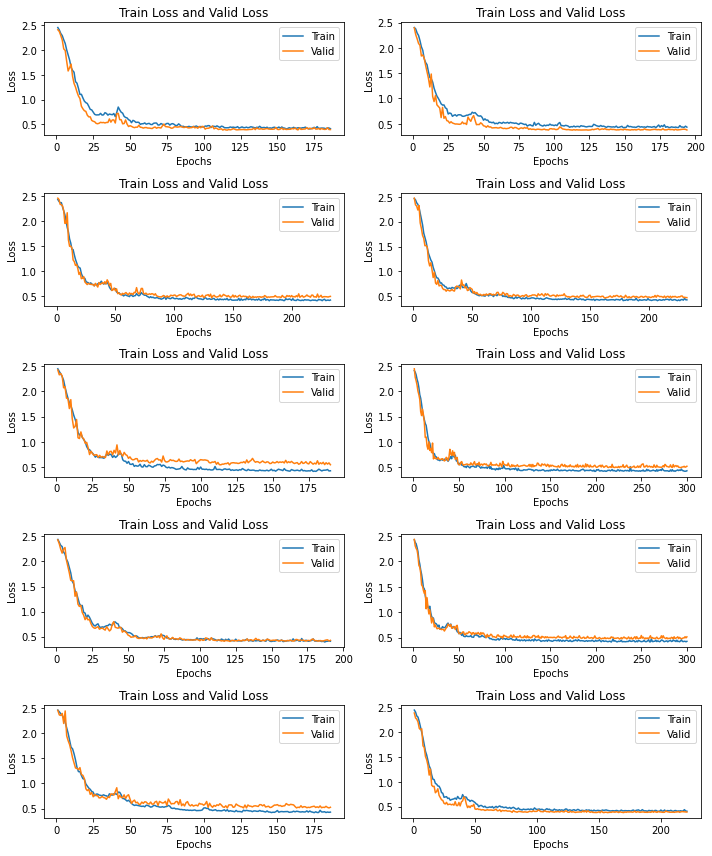

In [102]:
## fold별 epoch당 train loss와 valid loss의 변화
fig ,axs = plt.subplots(5, 2, figsize=(10, 12))
for i, ax in enumerate(axs.flatten()):
    show_loss_plot(net_epoch_train_loss[i], net_epoch_valid_loss[i], ax)
fig.tight_layout()

## test 예측

`-` softmax function을 취하면 11개의 원소 중 최대값의 인덱스 번호가 최종 예측값이 된다

In [103]:
def predict(model: nn.Module, dataloader, weight_save_path, is_prob=False) -> np.array:
    """저장된 모델의 가중치를 불러와서 dataloader의 각 데이터를 예측하여 반환"""
    model = model.to(device) ## device는 전역변수
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), len(target.unique()))) ## test예측값, target은 전역변수

    for weight in weight_path_list :
        model.load_state_dict(torch.load(weight, map_location=device))
        model.eval()
        probs = None
        
        with torch.no_grad(): 
            for test_batch in dataloader:
                test_batch = test_batch.to(device)
                outputs = model(test_batch).cpu().numpy()
                if probs is None:
                    probs = outputs
                else:
                    probs = np.concatenate([probs, outputs])

        test_probs += (probs / N_FOLD) ## N_FOLD는 전역변수
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1) ## 최대값과 인덱스

    if is_prob:
        return test_probs ## 각 컬럼별 확률값
    return test_preds ## 라벨값 

In [109]:
seed_everything(SEED)
test_dataset = CustomDataset(test_images, label_list=None, train_mode=False, transforms=get_transform(train_mode=False))  
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [110]:
net = CNN().to(device)

In [111]:
pred = predict(net, test_dataloader, SAVE_PATH)

In [112]:
label_pred = label_encoding_inverse_transform(pd.Series(pred))

In [113]:
submission['label'] = label_pred
submission.head()

,file_name,label
0,001.png,1
1,002.png,2
2,003.png,1
3,004.png,6
4,005.png,8


In [114]:
submission.to_csv('./Data/submission5.csv', index=False)

`-` 점수는 $0.9626168224$

### TTA 기법

In [115]:
def TTA_predict(model: nn.Module, dataloader, weight_save_path, n_tta: int = 5) -> np.array:
    """
    test_time_augmentation(test에도 transform을 적용, 일반화 능력 향상)를 사용하여 dataloader의 데이터를 예측
    dataloader에는 transform이 적용된 dataset을 가지고 있어야 함
    n_tta 횟수만큼 predict를 반복한다
    이 과정에서 여러번(n_tta) 무작위로 transform이 적용된 images의 각 label별 확률값들의 평균을 계산 후 최대값을 가지는 label을 반환한다
    """
    test_probs = np.zeros(shape=(len(dataloader.dataset), len(target.unique()))) ## test예측값, target은 전역변수
    for i in tqdm(range(n_tta)):
        test_probs += (predict(net, test_dataloader, SAVE_PATH, is_prob=True) / n_tta)

    _, test_preds = torch.max(torch.tensor(test_probs), dim=1) ## 최대값과 인덱스
    return test_preds ## 라벨값

In [116]:
test_transforms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=1),
        A.Normalize(mean=RGB_MEAN, std=RGB_STD), ## 255로 값들을 나누고 표준화
        ToTensor() ## 이미지 타입이 unit8이면 255로 나누고 아니면 냅두고 torch.Tensor로 변환
    ])

In [117]:
seed_everything(SEED)
test_dataset = CustomDataset(test_images, label_list=None, train_mode=False, transforms=test_transforms)  
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [118]:
net = CNN().to(device)

In [119]:
pred = TTA_predict(net, test_dataloader, SAVE_PATH, n_tta=5)

100%|██████████| 5/5 [00:29<00:00,  5.97s/it]


In [120]:
label_pred = label_encoding_inverse_transform(pd.Series(pred))

In [123]:
submission['label'] = label_pred
submission.head()

,file_name,label
0,001.png,1
1,002.png,2
2,003.png,1
3,004.png,6
4,005.png,8


In [124]:
submission.to_csv('./Data/submission_TTA4.csv', index=False)

`-` TTA 기법을 적용한 예측과 적용하지 않은 예측은 하나의 target을 제외하면 동일하다